# Mô hình phân loại sinh vật dưới biển

## I. Hướng đi của mô hình

__Cài đặt các thư viện cần thiết cho bài toán__

In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchsummary import summary
from prettytable import PrettyTable
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch
import shutil
import time
import os

__Hàm tiện ích để xem thông tin tập dữ liệu__

In [ ]:
def overview(path):
    labels = os.listdir(path)
    table = PrettyTable()
    table.add_column("Labels", labels)
    counts = [len(os.listdir(os.path.join(path, label))) for label in labels]
    table.add_column("Số lượng", counts)
    table.align = "l"
    return labels, counts, table

In [ ]:
def plotting(labels, counts):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=labels, y=counts, palette="flare", hue=labels, dodge=False)
    plt.title("Số lượng ảnh mỗi loài vật")
    plt.xlabel("Loài vật")
    plt.ylabel("Số lượng")
    plt.xticks(rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='baseline', 
        fontsize=12, color='black', xytext=(0, 5), 
        textcoords='offset points')
    plt.show()

In [ ]:
def show_image(image_path):
    plt.figure(figsize=(6, 4))
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

__Địa chỉ thư mục gốc__

In [ ]:
import zipfile
zip_path = 'archive.zip'
extract_to = 'archive'
if os.path.exists(extract_to) and os.path.isdir(extract_to):
    shutil.rmtree(extract_to)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Giải nén hoàn tất!")

In [ ]:
root_path = extract_to
root_path

In [ ]:
(labels, counts, table) = overview(root_path)
plotting(labels, counts)

### A. Chọn lọc nhãn
__Trong bài toán này, nhóm muốn tối ưu thời gian xây dựng mô hình và chất lượng mô hình, vì vậy nhóm quyết định loại bỏ các nhãn có số lượng nhỏ hơn 499, ngoại trừ nhóm Cá (vì đây là sinh vật cơ bản dưới biển). Dưới đây là các nhón sẽ giữ lại__

In [ ]:
labels_left = []
for label, count in zip(labels, counts):
    if count < 450:
        shutil.rmtree(f'./{root_path}/{label}')
        labels_left.append(label)
print('Các loài động vật loại bỏ:',labels_left, sep='\n')

__Danh sách các sinh vật dưới biển mới__

In [ ]:
(labels, counts, table) = overview(root_path)
plotting(labels, counts)

### B. Chọn lọc ảnh cho mô hình
__Trong quá trình huấn luyện, nhóm nhận ra một số ảnh trong một vài nhóm không có nhiều sự liên quan với sinh vật, hoặc ảnh có sinh vật nhưng rất khó nhìn. Nhóm quyết định lọc ra và loại bỏ chúng để đảm bảo chất lượng dữ liệu, một số ảnh không liên quan được minh họa bên dưới__

In [ ]:
#Ảnh hồ gươm không liên quan gì tới con rùa???
show_image(f'./{root_path}/Turtle_Tortoise/Turtle_Tortoise (207).jpg')

In [ ]:
#Ảnh con rùa nhưng lại có con voi, dễ gây nhập nhằng khi huấn luyện
show_image(f'./{root_path}/Turtle_Tortoise/Turtle_Tortoise (285).jpg')

In [ ]:
# Cũng là con rùa nhưng mà đây là bích họa, khó có thể phát hiện những họa tiết của rùa thật
show_image(f'./{root_path}/Turtle_Tortoise/Turtle_Tortoise (191).jpg')

__Loại bỏ các ảnh nhiễu nêu trên__

In [ ]:
dump_images = {
    "Octopus": [
        "145499187_2a272d8c12_o.jpg",
        "3077803917_d30414fe4b_b.jpg",
        "108207275_602ecab723_b.jpg",
        "126434824_e909f4ccfc_o.jpg",
        "375014431_dbceee7bc2_o.jpg",
        "527800056_b854d930f3_o.jpg",
        "1806379244_cb01e1f655_b.jpg",
        "4208556908_f798abbe82_o.jpg",
        "4579221526_34f22c4389_o.jpg",
        "5808603971_826e1bbccf_o.jpg",
        "6909956590_da96a270e9_o.jpg",
        "7056052431_d5444296da_o.jpg",
        "8107946717_0e35bd23d1_b.jpg",
        "8335666216_7a3dac8b2f_o.jpg",
        "8512487238_e5744046af_o.jpg",
        "11361195155_2eb1b746fd_b.jpg",
        "22534634179_eb8ec5337e_b.jpg",
        "28175082963_3786d54328_o.jpg",
        "28681305091_0cd4f097cd_o.jpg",
        "31648134791_173637264a_b.jpg",
        "36391246035_9a7ba3174b_o.jpg",
        "36391249725_493a3e9e48_o.jpg"
        
    ],
    "Fish": [
        "27825374776_f78132fc72_o.jpg",
        "2387855233_2d4386eb78_o.jpg",
        "1021968748_d291a5bd1b_o.jpg"
    ],
    "Turtle_Tortoise": [
        "Turtle_Tortoise (205).jpg",
        "Turtle_Tortoise (144).jpg",
        "Turtle_Tortoise (276).jpg",
        "Turtle_Tortoise (262).jpg",
        "Turtle_Tortoise (1838).jpg",
        "Turtle_Tortoise (1854).jpg",
        "Turtle_Tortoise (1839).jpg",
        "Turtle_Tortoise (201).jpg",
        "Turtle_Tortoise (186).jpg",
        "Turtle_Tortoise (253).jpg",
        "Turtle_Tortoise (191).jpg",
        "Turtle_Tortoise (284).jpg",
        "Turtle_Tortoise (285).jpg",
        "Turtle_Tortoise (726).jpg",
        "Turtle_Tortoise (255).jpg",
        "Turtle_Tortoise (261).jpg",
        "Turtle_Tortoise (92).jpg",
        "Turtle_Tortoise (207).jpg",
        "Turtle_Tortoise (131).jpg"
    ],
    "Sharks": [
        "97193331_06bb754c30_b.jpg",
        "97193335_f49f1d8e78_b.jpg",
        "3134364881_931944b0f5_o.jpg",
        "5220193178_85b1e37c89_o.jpg",
        "6155775279_325735ac1e_b.jpg",
        "6541148357_a3dd92ecdb_o.jpg",
        "8941813517_09e552e1f7_b.jpg",
        "14183781510_322d1956fb_b.jpg",
        "14183887337_d30da575ce_b.jpg",
        "14347244616_775dba43d4_b.jpg",
        "14390517883_1d6006d40d_b.jpg"
    ],
    "Whale": [
        "2736025397_0935b9cf72_o.jpg",
        "4984077075_f06d05debf_o.jpg",
        "6068711219_cbf7acc31a_o.jpg",
        "15394195553_8bae005267_o.jpg",
        "5652704967_effb830b38_b.jpg",
        "5653216820_0e8fb426ab_b.jpg",
        "6879132444_e70fa076af_b.jpg",
        "8407934317_f030d2d6a7_o.jpg",
        "14838287098_6c12847c22_o.jpg",
        "26447963806_642f68e62c_o.jpg",
        "27320330552_13f4a7a12a_o.jpg",
        "29809334851_ac68bb2e0c_o.jpg",
        "33707922003_ca0e254689_b.jpg",
    ]
}
for folder, files in dump_images.items():
    for file in files:
        file_path = os.path.join(root_path, folder, file)
        if os.path.exists(file_path):
            os.remove(file_path)

## II. Xây dựng mô hình

### A. Phân chia tập Huấn luyện và Kiểm tra

__Tạo 2 thư mục chhứa ảnh sẽ dùng để huấn luyện và để kiểm tra__

In [ ]:
train_path = './train/'
test_path = './test/'

In [ ]:
if os.path.exists(train_path) and os.path.isdir(train_path):
    shutil.rmtree(train_path)
if os.path.exists(test_path) and os.path.isdir(test_path):
    shutil.rmtree(test_path)

In [ ]:
os.makedirs('./train',exist_ok = True)
os.makedirs('./test',exist_ok = True)
for i in labels:
  os.makedirs('./train/'+i,exist_ok = True)
  os.makedirs('./test/'+i,exist_ok = True)

__Lấy ra địa chỉ các ảnh trong tập DL gốc, đánh nhãn bằng số tương ứng với thứ tự của thư mục__

In [ ]:
x_path = []
y = []
for i in labels:
  label_path = os.listdir(f'./{root_path}/'+i)
  jpeg_only = [image_path for image_path in label_path if image_path[-3:] == 'jpg']

  x_path.extend(jpeg_only)
  y.extend([i]*len(jpeg_only))

__Từ địa chỉ, nhãn, chia 70% Train 30% Test. Do một nhóm trung bình chỉ có khoảng 500 ảnh (khá là eo hẹp), vì vậy sẽ không chia theo hướng 60/15/15__

In [ ]:
X_train_path, X_test_path, y_train, y_test = train_test_split(x_path, y, test_size=0.2, random_state=42, stratify = y)

__Lần lượt đưa các địa chỉ ảnh đã chia bên trên vào các thư mục Train hoặc Test tương ứng__

In [ ]:
for label, path in zip(y_train, X_train_path):
    shutil.copy(f'./{root_path}/'+label+'/'+path, train_path+label+'/'+path)

for label, path in zip(y_test, X_test_path):
  shutil.copy(f'./{root_path}/'+label+'/'+path, test_path+label+'/'+path)

### B. Tăng cường dữ liệu

Thông qua biểu đồ ở trên, nhóm nhận thấy số lượng ảnh khá là ít để huấn luyện. Vì vậy nhóm quyết định tăng cường số lượng ảnh trong tập train mỗi nhóm.

__Phương pháp__: Với mỗi bức ảnh trong 1 nhóm, biến đổi nó ngẫu nhiên 10 lần thông qua Compose và lưu thành các ảnh mới. Các ảnh mới được tạo ra sẽ có đặc điểm khác với ảnh gốc như:
- Có 50% xác suất bị lật theo chiều ngang
- Có 50% xác suất bị lật theo chiều dọc
- Dịch sang trái hoặc sang phải ngẫu nhiên 20%, lên trên hoặc xuống dưới 40%
- Điều chỉnh độ sáng ngẫu nhiên từ 50% đến 90%
- Thu nhỏ xuống 80% hoặc phóng to lên tới 140% 1 phần ngẫu nhiên của bức ảnh
- Chuyển đổi ảnh sang dạng Tensor mà Pytorch có thể làm việc

__Ưu điểm__: 
- Tăng cường số lượng dữ liệu để huấn luyện, làm dữ liệu phong phú hơn
- Giúp mô hình học được dữ liệu ở nhiều điều kiện ánh sáng, góc độ khác nhau
- Tăng khả năng tổng quát của mô hình

__Định nghĩa Compose (bộ biến đổi), hàm tăng cường dữ liệu ảnh của 1 nhóm và 1 hàm kiểm soát việc tăng cường của mọi nhóm__

In [ ]:
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(size=240, scale=(0.8, 1.0)), 
    transforms.ToTensor()
])

def augmentation(base_path, target_class, save_path, target_size):
    global augment_transform
    class_path = os.path.join(base_path, target_class)
    image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    current_count = len(image_paths)

    if current_count >= target_size:
        print(f"Lớp {target_class} đã có đủ {current_count} ảnh, không cần augment.")
        return
        
    new_image_count = 0
    while current_count + new_image_count < target_size:
        for img_path in image_paths:
            for i in range(10):
                if current_count + new_image_count >= target_size:
                    break

                img = Image.open(img_path)
                augmented_img = augment_transform(img)

                original_filename = os.path.basename(img_path)
                name, ext = os.path.splitext(original_filename)
                augmented_filename = f"{name}_aug_{new_image_count + 1}{ext}"
                save_file_path = os.path.join(save_path, augmented_filename)
                augmented_img_pil = transforms.ToPILImage()(augmented_img)
                augmented_img_pil.save(save_file_path)

                new_image_count += 1

    print(f"Đã augment {new_image_count} ảnh cho lớp {target_class}.")

def augmentation_all(base_path, target_size, exclude_class=""):
    classes = os.listdir(base_path)
    for class_name in classes:
        if class_name != exclude_class:
            class_save_path = os.path.join(base_path, class_name)
            augmentation(base_path, class_name, class_save_path, target_size)
        else:
            print(f"Bỏ qua lớp {class_name}.")

__Số lượng ảnh augment dưới đây là số ảnh mới được tạo sau khi đi qua bộ biến đổi__

In [ ]:
augmentation_all(train_path, target_size=2000)

__Kiểm tra lại tập dữ liệu TRAIN sau khi được tăng cường__

In [ ]:
labels, counts, table = overview(train_path)
table

### C. Định nghĩa bộ quản lý dữ liệu

Đây là một phần cần thiết mỗi khi huấn luyện mô hình Pytorch, nó có khả năng __chia dữ liệu thành các nhóm nhỏ hơn__, giúp mô hình học nhanh hơn. Đặc biệt ở đây là nó có chắc năng __lazy evaluation__ (không tải toàn bộ dữ liệu vào bộ nhớ ngay lập tức mà chỉ tải dữ liệu khi cần thiết). Ở đây, chúng ta định nghĩa bộ quản lý dữ liệu tượng trưng cho train và test. Cứ mỗi 16 ảnh trong 1 tập được gộp vào thành 1 batch/nhóm

In [2]:
train_path = './train/'
test_path = './test/'
train_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((260, 260)),
    v2.ToDtype(torch.float32, scale=True), 
])

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=train_transform)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
)

__Kiểm tra dữ liệu ảnh sau trong 1 tập DataLoader__

In [ ]:
def plot_images(loader, num_images=3):
    plt.figure(figsize=(12, 12))
    images, labels = next(iter(loader))

    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

plot_images(train_loader)

In [3]:
from IPython.display import Image, display
from torchvision import models

### D. Định nghĩa mô hình

Sau nhiều lần thử nghiệm, nhóm quyết định chọn EfficientNet_B1 làm mô hình huấn luyện thay vì tự tạo ra mô hình mới.

__Lý do__:
- Nhóm đã thử nghiệm nhiều mô hình tùy chỉnh nhưng có hiệu suất thấp, tốn nhiều thời gian huấn luyện
- Ứng dụng lại những gì người đi trước đã làm tốt thay vì tạo mới giúp tiết kiệm thời gian nghiên cứu
- Các mô hình phổ biến có khả năng chuyển giao tốt hơn so với việc làm 1 mô hình mới
- Trong bài đánh giá của cuộc thi ImageNet (đang tìm hiểu năm), ta có thể thấy Accuracy của B1 có thể chấp nhận được với số lượng tham số khá khiêm tốn:

__Ưu điểm của EfficientNet_B2:__
- Phù hợp với lượng dữ liệu trong bài của nhóm
- Là một trong những kiến trúc CNN mới nhất
- Tiết kiệm tài nguyên, số lượng tham số ít hơn Resnet, DenseNet

In [ ]:
display(Image(url='https://blog.roboflow.com/content/images/2024/04/image-1085.webp', width=500))

__Nạp kiến trúc của EfficientNet_B2 vào mô hình, sử dụng trọng số mà nó đã được huấn luyện từ trước__

In [4]:
from torchvision import models
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = models.efficientnet_b2(weights='EfficientNet_B2_Weights.DEFAULT')
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)
        
    def forward(self, x):
        x = self.efficientnet(x)
        return x

__Tạo đối tượng mô hình và đưa vào bộ xử lý (máy tự nhận biết nên chọn GPU/CPU)__

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = MyModel(22)
model = model.to(device)
print(device)

cuda


__Diễn giải kiến trúc của EfficientNet__

In [ ]:
model.eval()
summary(model, input_size=(3, 260, 260))

### E. Huấn luyện mô hình

__Cài đặt siêu tham số__: Số vòng lặp huấn luyện, learning rate. 

__Cài đặt các hàm chi phí__: Adam.

__Tiện ích kiểm soát__: ReduceLROnPleteau - nếu phát hiện loss bắt đầu cao hơn 2 lần, giảm learning_rate đi 50%.

In [6]:
num_epochs = 50
learning_rate = 0.0005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 50, Loss: 0.001299281,  Time/epoch: -300.03628270000263


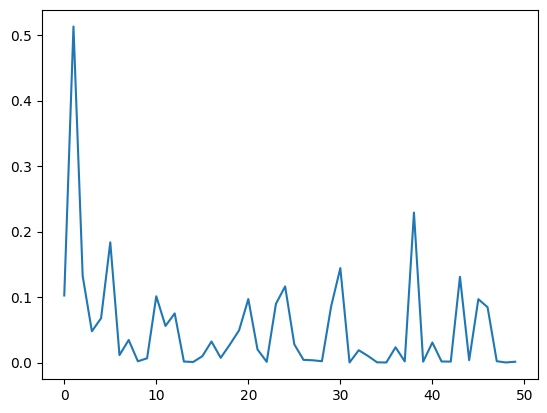

Total runtime -15011.254428299999
Epoch có loss thấp nhất: 36
Min loss: 0.00014447352441493422


In [7]:
import timeit
from IPython.display import clear_output
device = torch.device("cuda")
model.to(device)

output_loss = []
min_loss = 1
t_epoch = 0
start = timeit.default_timer()
for epoch in range(1,num_epochs+1):
  epoch_start = timeit.default_timer()
  for batch in train_loader:
    x, y = batch[0].to(device), batch[1].to(device)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  output_loss.append(loss.item())
  epoch_end = timeit.default_timer()
  if epoch % 1 == 0:
    clear_output(wait=True)
    if loss.item()<min_loss:
        min_loss = loss.item()
        if os.path.exists('./best_model.pth'):
            os.remove('./best_model.pth')
            print("clear")# Xóa file
        torch.save(model.state_dict(), 'best_model.pth')
        print("saved")
        t_epoch = epoch
    print(f'Epoch: {epoch}, Loss: {loss.item():.9f},  Time/epoch: {epoch_start - epoch_end}')
    plt.plot(output_loss)
    plt.show()
end = timeit.default_timer()
print(f'Total runtime {start - end}')
print(f'Epoch có loss thấp nhất: {t_epoch}')
print(f'Min loss: {min_loss}')

### F. Đánh giá mô hình

__Tính độ chính xác tổng thể__

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

__Tính bảng kiểm tra phân loại (vui lòng chụp lại gửi cho tôi cái này)__

In [ ]:
all_labels = []
all_predictions = []
animals = overview(train_path)[0]

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy()) 
        all_predictions.extend(predicted.cpu().numpy())

report = classification_report(all_labels, all_predictions, target_names=animals)
print(report)

__Lưu mô hình__

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted_not_good.pt')